# Analyzing 'sit-lie' arrests by LAPD: 2010-19

### Load Python tools

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib
import geojson
import json
import jenkspy
import numpy as np
from earthpy import clip as cl
from altair import datum
import altair as alt
alt.renderers.enable('notebook')
import altair_latimes as lat
alt.themes.register('latimes', lat.theme)
alt.themes.enable('latimes')
pd.options.display.max_columns = 50
pd.options.display.max_rows = 1000

#### Read in arrests data from city portal

In [2]:
# https://data.lacity.org/api/views/yru6-6re4/rows.csv?accessType=DOWNLOAD
arrests = pd.read_csv('/Users/mhustiles/data/data/LA/Arrest_Data_from_2010_to_Present.csv')

#### How many arrest cases are in the database?

In [3]:
len(arrests)

1305147

#### Clean up arrests DataFrame

In [4]:
arrests.columns = arrests.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
arrests['arrest_date'] = pd.to_datetime(arrests['arrest_date'], format='%m/%d/%Y')
arrests['year'] = arrests['arrest_date'].dt.year
arrests['quarter'] = arrests['arrest_date'].dt.quarter
arrests['day'] = arrests['arrest_date'].dt.day
arrests['month'] = arrests['arrest_date'].dt.month
arrests['monthname'] = arrests['arrest_date'].dt.month_name()
arrests[['report_id', 'time', 'area_id', 'charge_group_code', 'reporting_district', 'year', 'month', 'day']] = \
arrests[['report_id', 'time', 'area_id', 'charge_group_code', 'reporting_district', 'year', 'month','day']].astype(str)
arrests['charge_group_code'] = arrests['charge_group_code'].str.replace('.0', '', regex=False)
arrests['weekday'] = arrests['arrest_date'].dt.weekday_name
arrests['time'] = arrests['time'].str.replace('.0','', regex=False)
arrests['time'] = arrests['time'].str.zfill(4)
arrests['hour'] = arrests['time'].str[:2]
arrests['minute'] = arrests['time'].str[2:]
arrests = arrests[arrests['hour'] != '0n']
arrests = arrests[arrests['hour'] != '24']
arrests.drop('cross_street', axis=1, inplace=True)

In [5]:
arrests.head()

,report_id,arrest_date,time,area_id,area_name,reporting_district,age,sex_code,descent_code,charge_group_code,charge_group_description,arrest_type_code,charge,charge_description,address,location,year,quarter,day,month,monthname,weekday,hour,minute
0,5765501,2019-10-05,0935,5,Harbor,526,49,F,W,24,Miscellaneous Other Violations,M,597(B)PC,USE WORK ANIMAL W/CRUELTY/ABUSE,900 ISLAND AV,"(33.7815, -118.2667)",2019,4,5,10,October,Saturday,09,35
1,5765365,2019-10-05,0259,21,Topanga,2177,29,M,B,22,Driving Under Influence,M,23152(A)VC,DRUNK DRIVING ALCOHOL/DRUGS,DE SOTO AV,"(34.1689, -118.5882)",2019,4,5,10,October,Saturday,02,59
2,191117610,2019-10-05,1300,11,Northeast,1139,51,M,H,16,Narcotic Drug Laws,M,11364(A)HS,POSS DEVICE/INSTRUMT/PARAPHERNALIA,AVENUE 59,"(34.1095, -118.1903)",2019,4,5,10,October,Saturday,13,00
3,5765280,2019-10-05,0020,20,Olympic,2002,29,M,W,13,Prostitution/Allied,M,647(B)PC,PROSTITUTION,WESTERN AV,"(34.0783, -118.3092)",2019,4,5,10,October,Saturday,00,20
4,5765238,2019-10-05,0001,9,Van Nuys,974,62,F,W,22,Driving Under Influence,M,23152(A)VC,DRUNK DRIVING ALCOHOL/DRUGS,VAN NUYS,"(34.1569, -118.4487)",2019,4,5,10,October,Saturday,00,01


#### Highlight nighttime hours

In [6]:
night = ['01', '02', '03', '04', '05', '22', '23', '00']
arrests['night'] = arrests['hour'].isin(night)
night_arrests = arrests[arrests['hour'].isin(night)]

#### Separate location field into lat/lon

In [7]:
arrests['location'] = arrests.location.str.replace('(', '').str.replace(')', '')

lat = []
lon = []

for row in arrests['location']:
    try:
        lat.append(row.split(',')[0])
        lon.append(row.split(',')[1])
    except:
        lat.append(np.NaN)
        lon.append(np.NaN)

arrests['latitude'] = lat
arrests['longitude'] = lon
arrests['latitude'] = arrests['latitude'].astype(float)
arrests['longitude'] = arrests['longitude'].astype(float)

#### Recode descent names into something useful

In [8]:
descent_recode ={'A':"Asian",'B':"Black",'C':"Asian",'D':"Asian",'F':"Asian",'G':"Asian",'H':"Hispanic",'I':"American Indian/Alaskan Native",'J':"Asian",'K':"Asian",'L':"Asian",'O':"Other",'P':"Asian",'S':"Asian",'U':"Asian",'V':"Asian",'W':"White",'X':"Other",'Z':"Asian"}

In [9]:
arrests['descent_description'] = arrests['descent_code'].map(descent_recode)

In [10]:
arrest_type_recode ={'F':"Felony",'I':"Infraction",'M':"Misdemeanor",'O':"Other"}

In [11]:
arrests['arrest_type_description'] = arrests['arrest_type_code'].map(arrest_type_recode)

In [12]:
arrests

,report_id,arrest_date,time,area_id,area_name,reporting_district,age,sex_code,descent_code,charge_group_code,charge_group_description,arrest_type_code,charge,charge_description,address,location,year,quarter,day,month,monthname,weekday,hour,minute,night,latitude,longitude,descent_description,arrest_type_description
0,5765501,2019-10-05,0935,5,Harbor,526,49,F,W,24,Miscellaneous Other Violations,M,597(B)PC,USE WORK ANIMAL W/CRUELTY/ABUSE,900 ISLAND AV,"33.7815, -118.2667",2019,4,5,10,October,Saturday,09,35,False,33.7815,-118.2667,White,Misdemeanor
1,5765365,2019-10-05,0259,21,Topanga,2177,29,M,B,22,Driving Under Influence,M,23152(A)VC,DRUNK DRIVING ALCOHOL/DRUGS,DE SOTO AV,"34.1689, -118.5882",2019,4,5,10,October,Saturday,02,59,True,34.1689,-118.5882,Black,Misdemeanor
2,191117610,2019-10-05,1300,11,Northeast,1139,51,M,H,16,Narcotic Drug Laws,M,11364(A)HS,POSS DEVICE/INSTRUMT/PARAPHERNALIA,AVENUE 59,"34.1095, -118.1903",2019,4,5,10,October,Saturday,13,00,False,34.1095,-118.1903,Hispanic,Misdemeanor
3,5765280,2019-10-05,0020,20,Olympic,2002,29,M,W,13,Prostitution/Allied,M,647(B)PC,PROSTITUTION,WESTERN AV,"34.0783, -118.3092",2019,4,5,10,October,Saturday,00,20,True,34.0783,-118.3092,White,Misdemeanor
4,5765238,2019-10-05,0001,9,Van Nuys,974,62,F,W,22,Driving Under Influence,M,23152(A)VC,DRUNK DRIVING ALCOHOL/DRUGS,VAN NUYS,"34.1569, -118.4487",2019,4,5,10,October,Saturday,00,01,True,34.1569,-118.4487,White,Misdemeanor
5,5765400,2019-10-05,0411,1,Central,191,29,M,H,22,Driving Under Influence,M,23152(A)VC,DRUNK DRIVING ALCOHOL/DRUGS,BELLEVUE,"34.0388, -118.2717",2019,4,5,10,October,Saturday,04,11,True,34.0388,-118.2717,Hispanic,Misdemeanor
6,5765272,2019-10-05,0020,20,Olympic,2004,29,M,W,13,Prostitution/Allied,M,647(B)PC,PROSTITUTION,WESTERN AV,"34.0783, -118.3092",2019,4,5,10,October,Saturday,00,20,True,34.0783,-118.3092,White,Misdemeanor
7,5765318,2019-10-05,0200,20,Olympic,2002,27,F,B,13,Prostitution/Allied,M,647(B)PC,PROSTITUTION,MELROSE AV,"34.0835, -118.3091",2019,4,5,10,October,Saturday,02,00,True,34.0835,-118.3091,Black,Misdemeanor
8,5765337,2019-10-05,0212,1,Central,119,22,M,H,22,Driving Under Influence,M,23152(A)VC,DRUNK DRIVING ALCOHOL/DRUGS,RIVERSIDE,"34.0577, -118.2318",2019,4,5,10,October,Saturday,02,12,True,34.0577,-118.2318,Hispanic,Misdemeanor
9,191117612,2019-10-05,1300,11,Northeast,1139,49,F,H,16,Narcotic Drug Laws,M,11377(A)HS,POSSESSION CONTROLLED SUBSTANCE,AVENUE 59,"34.1095, -118.1903",2019,4,5,10,October,Saturday,13,00,False,34.1095,-118.1903,Hispanic,Misdemeanor


#### Count the arrests by charge type

In [13]:
charges_grouped = arrests.groupby(['charge', 'charge_description']).agg('size').sort_values(ascending=False).reset_index(name='total')

#### Top 10 arrest charges 2010-2019

In [14]:
charges_grouped.head(10)

,charge,charge_description,total
0,23152(A)VC,DRUNK DRIVING ALCOHOL/DRUGS,97324
1,41.27CLAMC,DRINKING IN PUBLIC,93527
2,273.5(A)PC,CORPORAL INJURY ON SPOUSE/COHABITANT/ETC,46259
3,11377(A)HS,POSSESSION CONTROLLED SUBSTANCE,40832
4,853.7PC,FTA AFTER WRITTEN PROMISE,31481
5,11350(A)HS,POSSESSION NARCOTIC CONTROLLED SUBSTANCE,29350
6,647(B)PC,PROSTITUTION,26591
7,25620BP,OPEN ALCOHOLIC BEV IN PUBLIC PARK/PLACE,25949
8,41.18DLAMC,SIT/LIE/SLEEP SIDEWALK OR STREET,25700
9,LAMC,LOS ANGELES MUNICIPAL CODE,24574


#### Isolate all 'sit-lie' cases and just 41.18D

In [15]:
sit_lie_all = arrests[arrests.charge.str.contains('41.18')]
sit_lie_d = arrests[arrests['charge'] == '41.18DLAMC']
sidewalk_property_cases = arrests[arrests.charge.str.contains('56.11')]

In [16]:
# How many 'sit-lie' cases total?
len(sit_lie_all)

36947

In [17]:
# How many '41.18D' cases total?
len(sit_lie_d)

28696

In [18]:
# How many '56.11' cases total?
len(sidewalk_property_cases)

3909

---

### Look more closely at the 'sit-lie' cases

In [19]:
sit_lie_all['sex_code'].value_counts('normalize').round(4)*100

M    74.1
F    25.9
Name: sex_code, dtype: float64

In [20]:
sit_lie_all['descent_description'].value_counts('normalize').round(4)*100

Black                             43.62
White                             33.19
Hispanic                          20.26
Other                              2.37
Asian                              0.54
American Indian/Alaskan Native     0.02
Name: descent_description, dtype: float64

In [21]:
sit_lie_all['arrest_type_description'].value_counts('normalize').round(4)*100

Misdemeanor    87.01
Infraction     12.98
Other           0.01
Name: arrest_type_description, dtype: float64

In [22]:
sit_lie_all['night'].value_counts('normalize').round(4)*100

False    95.43
True      4.57
Name: night, dtype: float64

In [23]:
sit_lie_years = sit_lie_all.groupby(['year'])\
.agg('size').sort_values(ascending=False).reset_index(name='total')

sit_lie_years.sort_values(by='year', inplace=True)

In [24]:
sit_lie_quarters = sit_lie_all.groupby(['quarter', 'year'])\
.agg('size').sort_values(ascending=False).reset_index(name='total')

sit_lie_quarters.sort_values(by='year', inplace=True)

In [25]:
sit_lie_quarters.head(10)

,quarter,year,total
31,3,2010,375
32,4,2010,304
28,2,2010,467
35,1,2010,249
34,2,2011,286
30,3,2011,389
37,1,2011,226
27,4,2011,495
7,4,2012,1331
24,2,2012,817


In [26]:
sit_lie_quarters.to_csv('output/sit_lie_quarters.csv')

#### Chart the years

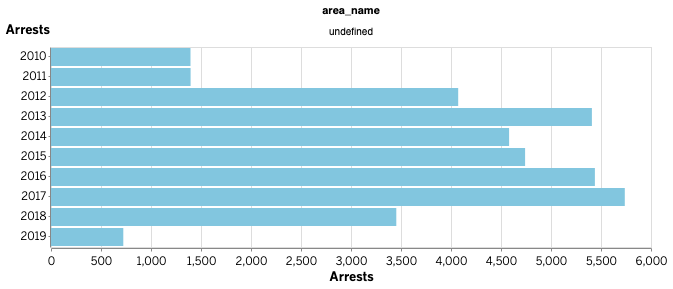

In [27]:
alt.Chart(sit_lie_years).mark_bar().encode(
    y=alt.Y('year:N', title="Arrests", axis=alt.Axis(format='', tickCount=5)),
    x=alt.X("total:Q", title="Arrests"),
    facet='area_name:N',
).properties(height=200, width=600)

#### Group all 'sit-lie' cases by charge, location, year — and count arrests

In [28]:
charges_grouped_sit_lie_all = sit_lie_all.groupby\
(['charge', 'charge_description','area_name','reporting_district', 'year'])\
.agg('size').sort_values(ascending=False).reset_index()

In [29]:
charges_grouped_sit_lie_all.columns = ['charge', 'charge_description', 'area_name', 'reporting_district', 'year','total']
charges_grouped_sit_lie_all['reporting_district'] = charges_grouped_sit_lie_all['reporting_district'].astype(str)

In [30]:
charges_grouped_sit_lie_all.head()

,charge,charge_description,area_name,reporting_district,year,total
0,41.18DLAMC,SIT/LIE/SLEEP SIDEWALK OR STREET,Central,157,2016,572
1,41.18DLAMC,SIT/LIE/SLEEP SIDEWALK OR STREET,Central,111,2017,427
2,41.18DLAMC,SIT/LIE/SLEEP SIDEWALK OR STREET,Central,158,2013,425
3,41.18DLAMC,SIT/LIE/SLEEP SIDEWALK OR STREET,Central,157,2014,423
4,41.18DLAMC,SIT/LIE/SLEEP SIDEWALK OR STREET,Central,157,2013,388


In [31]:
districts_counts_years_pivot = pd.pivot_table(charges_grouped_sit_lie_all, values='total', \
index=['reporting_district'], columns=['year'], aggfunc=np.sum, fill_value=0).sort_values(by='2019', ascending=False).reset_index()

districts_counts_years_pivot.head()

year,reporting_district,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,156,10,39,223,214,150,134,199,317,153,22
1,166,5,39,232,282,196,100,79,189,116,17
2,176,1,14,52,46,22,65,155,132,71,16
3,1307,11,35,93,147,46,44,18,21,17,15
4,165,1,3,34,25,30,16,11,81,46,14


---

## Geography

#### Import and clean up LAPD reporting districts

In [32]:
# convert from shp to geojson
!mapshaper '/Users/mhustiles/data/github/notebooks/arrests/input/LAPD_Reporting_Districts/*.shp'\
-o format=geojson\
'/Users/mhustiles/data/github/notebooks/arrests/output/lapd_reporting_districts.json'

reporting_districts_src = gpd.read_file('/Users/mhustiles/data/github/notebooks/arrests/output/lapd_reporting_districts.json')

/bin/sh: mapshaper: command not found


In [33]:
reporting_districts_src.plot()

In [34]:
reporting_districts_src.columns = reporting_districts_src.columns.str.strip().\
str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

In [35]:
reporting_districts_src = reporting_districts_src.rename(columns={"repdist": "reporting_district"})

In [36]:
lapd_districts = reporting_districts_src[['reporting_district', 'aprec', 'area', 'geometry']]

---

#### Import and clean up LAPD divisions

In [37]:
# convert from shp to geojson
!mapshaper '/Users/mhustiles/data/github/notebooks/arrests/input/LAPD_Divisions/LAPD_Divisions.shp'\
-o format=geojson\
'/Users/mhustiles/data/github/notebooks/arrests/output/lapd_divisions.json'

divisions_src = gpd.read_file('/Users/mhustiles/data/github/notebooks/arrests/output/lapd_divisions.json')

/bin/sh: mapshaper: command not found


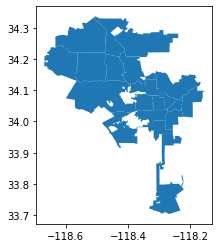

In [38]:
divisions_src.plot()

In [39]:
divisions_src.columns = divisions_src.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

In [40]:
divisions = divisions_src[['aprec', 'prec', 'area', 'geometry']]

#### Import LA Times neighborhoods

In [41]:
hoodssrc = gpd.read_file('/Users/mhustiles/data/github/notebooks/arrests/input/custom-la-hoods-skid-row.geojson')

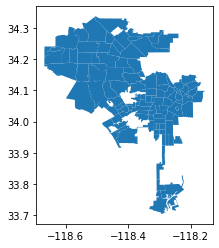

In [42]:
hoodssrc.columns = hoodssrc.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
hoodssrc.plot()

#### Trim the dataframe

In [43]:
hoods = hoodssrc[['name', 'geometry']]

In [44]:
hoods.head()

,name,geometry
0,Adams-Normandie,(POLYGON ((-118.3090080000001 34.0374109991240...
1,Arleta,(POLYGON ((-118.4220150000001 34.2241029991218...
2,Arlington Heights,"(POLYGON ((-118.315909 34.05261099912384, -118..."
3,Atwater Village,(POLYGON ((-118.2783247308968 34.1530071452962...
4,Baldwin Hills/Crenshaw,(POLYGON ((-118.3562610000001 34.0248359991243...


---

## Merge 'sit-lie' arrests data with geography

#### Relate all 'sit-lie' arrests to LA Times neighborhoods

In [45]:
sit_lie_all_gdf = gpd.GeoDataFrame(sit_lie_all, \
geometry=gpd.points_from_xy(sit_lie_all.longitude, sit_lie_all.latitude))

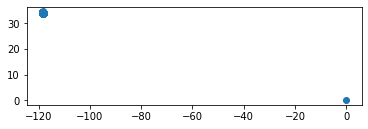

In [46]:
sit_lie_all_gdf.plot()

#### Let's remove the stray lat/lon cases

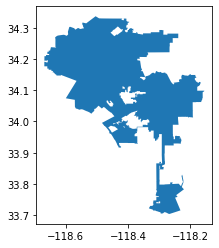

In [47]:
#Read city of Los Angeles boundary file
la = gpd.read_file('input/la_city_boundary/la_city_boundary_1570551157861.geojson')
la.plot()

In [48]:
# Remove stray LA arrests with the clip_data module
sit_lie_all_gdf_clipped = cl.clip_shp(sit_lie_all_gdf, la)

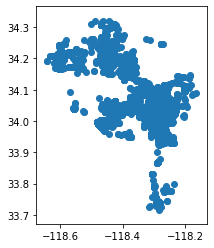

In [49]:
sit_lie_all_gdf_clipped.plot()

In [50]:
sit_lie_all_gdf_clipped.crs = {'init': "epsg:4326"}
sit_lie_all_gdf.crs = {'init': "epsg:4326"}

In [51]:
sit_lie_all_gdf_clipped.to_file('output/sit_lie_all_gdf_clipped.geojson', driver='GeoJSON')

In [52]:
sit_lie_all_gdf_clipped_2019_hollywood = sit_lie_all_gdf_clipped[(sit_lie_all_gdf_clipped['arrest_date'] > '2019/01/01') \
& (sit_lie_all_gdf_clipped['area_name'] == 'Hollywood')]
sit_lie_all_gdf_clipped_2019 = sit_lie_all_gdf_clipped[(sit_lie_all_gdf_clipped['arrest_date'] > '2019/01/01')]

In [53]:
sit_lie_all_gdf_clipped_2019_hollywood.to_csv('output/sit_lie_all_gdf_clipped_2019_hollywood.csv')
sit_lie_all_gdf_clipped_2019.to_csv('output/sit_lie_all_gdf_clipped_2019.csv')

In [54]:
sit_lie_all_gdf_clipped.crs = {'init': "epsg:4326"}

In [55]:
sit_lie_all_hoods = gpd.sjoin(sit_lie_all_gdf, hoods, op='within', how="inner")

#### 'Busy' neighborhoods: Skid Row, elsewhere Downtown, Venice, Hollywood

In [56]:
busy_hoods = ['Skid Row', 'Downtown', 'Venice', 'Hollywood']

In [57]:
sit_lie_all_hoods['busy'] = sit_lie_all_hoods['name'].isin(busy_hoods)

In [58]:
sit_lie_all_hoods.iloc[10]

report_id                                                 192110432
arrest_date                                     2019-05-18 00:00:00
time                                                           1110
area_id                                                          21
area_name                                                   Topanga
reporting_district                                             2177
age                                                              48
sex_code                                                          M
descent_code                                                      W
charge_group_code                                                20
charge_group_description                         Disorderly Conduct
arrest_type_code                                                  M
charge                                                  41.18(A)LAM
charge_description          LOITER/OBSTRUCT STREET/SIDEWALK/ETC****
address                             WINNETKA    

In [59]:
sit_lie_all_hoods_slim = sit_lie_all_hoods[['report_id','arrest_date','time','area_id','area_name','reporting_district','age','sex_code','descent_code','charge_group_code','charge_group_description','arrest_type_code','charge','charge_description','year','month','weekday','name', 'busy']]

In [60]:
sit_lie_all_hoods_slim.head()
len(sit_lie_all_hoods_slim)

36763

#### Totals by neighborhood

In [61]:
hood_counts = sit_lie_all_hoods_slim.groupby(['name']).agg('size').sort_values(ascending=False).reset_index(name='total')

In [62]:
#Large neighborhoods
hood_counts_busy = hood_counts[hood_counts['total'] > 200 ].sort_values(by='total', ascending=False)

In [63]:
hood_counts['total'].sum()

36763

In [64]:
hood_counts['share'] = ((hood_counts['total'] / hood_counts['total'].sum())*100).round()
hood_counts.head()

,name,total,share
0,Skid Row,11947,32.0
1,Downtown,7372,20.0
2,Hollywood,5890,16.0
3,Venice,4994,14.0
4,Sawtelle,606,2.0


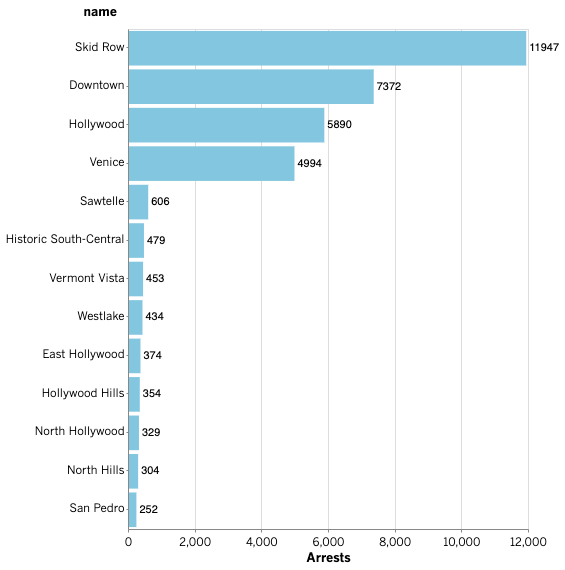

In [65]:
bars = alt.Chart(hood_counts_busy).mark_bar().encode(
    x=alt.X('total:Q', title="Arrests", axis=alt.Axis(format='', tickCount=6)), 
    y=alt.Y(
        'name:N',
        sort=alt.EncodingSortField(
            field="total",  # The field to use for the sort
            order="descending"  # The order to sort in
        )
    )
)
text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='total:Q'
)
(bars + text).properties(height=500, width=400)

In [66]:
hood_counts_years = sit_lie_all_hoods_slim.groupby(['name', 'year', 'busy']).agg('size').sort_values(ascending=False).reset_index(name='total')

In [67]:
hood_counts_years.head()

,name,year,busy,total
0,Skid Row,2017,True,2225
1,Skid Row,2013,True,2055
2,Skid Row,2016,True,1894
3,Skid Row,2014,True,1853
4,Skid Row,2012,True,1539


#### What's the share of the arrests in the 'busy' neighborhoods: Skid row, elsewhere Downtown, Venice, Hollywood?

In [68]:
hood_counts_years_grouped = sit_lie_all_hoods_slim.groupby(['year', 'busy']).agg('size').sort_values(ascending=False).reset_index(name='total')

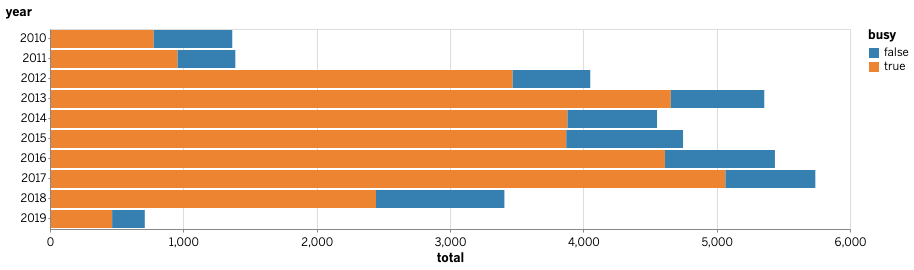

In [69]:
alt.Chart(hood_counts_years_grouped).mark_bar().encode(
    x=alt.X('total', axis=alt.Axis(tickCount=6)),
    y='year',
    color='busy'
)

#### Pivot on year and neighborhood

In [70]:
hood_counts_years_pivot = pd.pivot_table(hood_counts_years, values='total', index=['name'], columns=['year'], aggfunc=np.sum, fill_value=0).sort_values(by='2019', ascending=False).reset_index()
hood_counts_years_pivot.head(10)

year,name,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Venice,93,45,496,857,788,835,704,600,415,161
1,Downtown,39,132,618,945,780,1170,1401,1520,657,110
2,Skid Row,57,220,1539,2055,1853,1332,1894,2225,667,105
3,Hollywood,589,560,817,799,460,535,613,721,706,90
4,Westlake,2,12,38,37,18,17,72,65,118,55
5,Sawtelle,2,4,9,3,12,26,88,169,245,48
6,San Pedro,20,0,0,1,0,9,81,35,91,15
7,Woodland Hills,0,0,2,3,0,1,3,7,10,14
8,East Hollywood,34,37,47,27,23,14,124,24,32,12
9,Pico-Union,6,23,6,22,3,0,3,5,16,10


#### Filter neighborhoods to the busiest: Skid Row, elsewhere downtown, Hollywood and Venice

In [71]:
hood_counts_years_busy = hood_counts_years[hood_counts_years['busy'] == True]

In [72]:
hood_counts_years_busy.head()

,name,year,busy,total
0,Skid Row,2017,True,2225
1,Skid Row,2013,True,2055
2,Skid Row,2016,True,1894
3,Skid Row,2014,True,1853
4,Skid Row,2012,True,1539


#### Arrests by year in Downtown, Hollywood and Venice

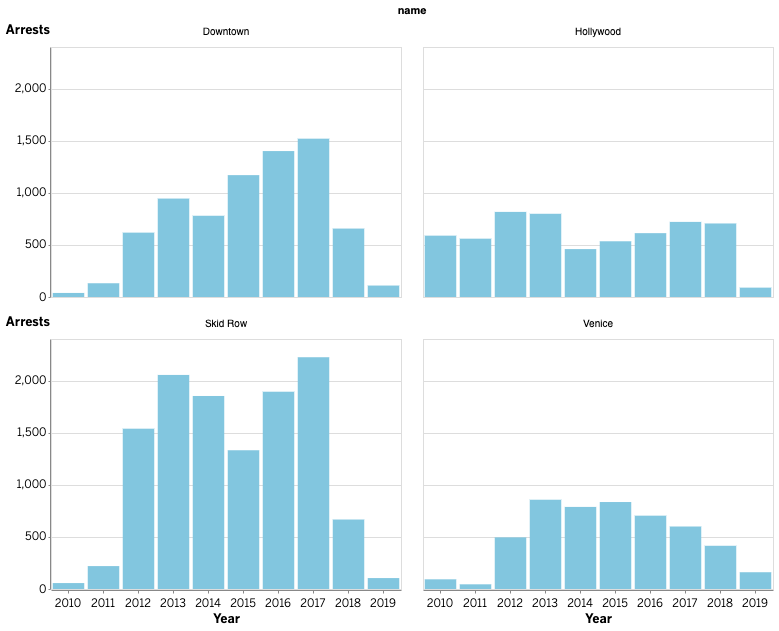

In [73]:
alt.Chart(hood_counts_years_busy).mark_bar().encode(
    y=alt.Y('total:Q', title="Arrests", axis=alt.Axis(format='', tickCount=6),
        sort=alt.EncodingSortField(
            field="year",  # The field to use for the sort
            order="ascending"  # The order to sort in
        )), 
    x=alt.X(
        'year:N', axis=alt.Axis(format='', title='Year')
    ),
    facet='name:O').properties(
    columns=2,
    width=350,
    height=250
)

---

#### Merge districts with pivoted arrest totals

In [74]:
districts_counts_years_pivot_geo = districts.merge(districts_counts_years_pivot, on='reporting_district').sort_values(by='2019', ascending=False)

NameError: name 'districts' is not defined

In [ ]:
districts_counts_years_pivot_geo.head()

In [ ]:
districts_sit_lie_grouped_geo = districts.merge(charges_grouped_sit_lie_all, on='reporting_district').sort_values(by='year', ascending=False)

In [ ]:
districts_sit_lie_grouped_geo.head()

#### Export to GeoJSON

In [ ]:
districts_counts_years_pivot_geo.to_file('/Users/mhustiles/data/github/notebooks/arrests/output/districts_counts_years_pivot_geo.json', driver='GeoJSON')

---

## Mapping

In [ ]:
breaks = jenkspy.jenks_breaks(list(districts_sit_lie_grouped_geo.total), nb_class=5)
breaks

In [ ]:
def get_group(value):
    for i, b in enumerate(breaks):
        if value <= breaks[i+1]:
            return i

In [ ]:
districts_sit_lie_grouped_geo['arrest_group'] = districts_sit_lie_grouped_geo.total.apply(get_group)

In [ ]:
districts_sit_lie_grouped_geo.to_file('/Users/mhustiles/data/github/notebooks/arrests/output/districts_sit_lie_grouped_geo.json', driver='GeoJSON')

In [ ]:
districts_sit_lie_grouped_geo.head()

In [ ]:
sit_lie_geojson = json.loads(districts_sit_lie_grouped_geo.to_json())
sit_lie_features = alt.Data(values=sit_lie_geojson['features'])

In [ ]:
districts_geojson = json.loads(districts.to_json())
districts_features = alt.Data(values=districts_geojson['features'])

In [ ]:
hoods_geojson = json.loads(hoods.to_json())
hoods_features = alt.Data(values=hoods_geojson['features'])

In [ ]:
districts_geojson_pivot = json.loads(districts_counts_years_pivot_geo.to_json())
districts_geojson_pivot_features = alt.Data(values=districts_geojson_pivot['features'])

In [ ]:
basemap = alt.Chart(districts_features).mark_geoshape(
    fill='lightgray',
    stroke=''
).project('mercator')

groups = alt.Chart(sit_lie_features).mark_geoshape(
    stroke='white'
).encode(
    color='properties.arrest_group:Q'
).transform_filter(
    alt.FieldEqualPredicate(field='properties.year', equal='2016')
)

hoodsmaps = alt.Chart(hoods_features).mark_geoshape(
    fill='',
    stroke='#999999',
    strokeWidth=.2
)

(basemap+groups+hoodsmaps).properties(
    width=600,
    height=600
)

In [ ]:
variable_list = ['properties.2010','properties.2011','properties.2012','properties.2013','properties.2014','properties.2015','properties.2016','properties.2017','properties.2018','properties.2019']

In [ ]:
alt.Chart(districts_features).mark_geoshape().encode(
    alt.Color(alt.repeat('row'), type='quantitative')
).transform_lookup(
    lookup='properties.reporting_district',
    from_=alt.LookupData(districts_geojson_pivot_features, 'properties.reporting_district', variable_list)
).properties(
    width=500,
    height=500
).repeat(
    row=variable_list
).resolve_scale(
    color='shared'
)

#### Group all 'sit-lie' cases by place and time

In [ ]:
time_sit_lie_hoods = sit_lie_all_hoods.groupby(['name', 'year', 'hour', 'night']).agg('size').sort_values(ascending=False).reset_index()

In [ ]:
time_sit_lie_hoods.columns = ['name', 'year','hour', 'night', 'total']

In [ ]:
time_sit_lie_hoods.head()

In [ ]:
time_sit_lie_hoods_busy = time_sit_lie_hoods[time_sit_lie_hoods['name'].isin(busy_hoods)]

In [ ]:
alt.Chart(time_sit_lie_hoods).mark_bar().encode(
    x='hour:O',
    y="total:Q",
    color=alt.condition(
        alt.datum.night == True,
        alt.value('orange'), 
        alt.value('#82c6df')
    )
).properties(
    title='\'Sit-lie\' arrests in all neighborhoods, by hour',
    columns=2,
    width=320,
    height=300
)

In [ ]:
alt.Chart(time_sit_lie_hoods_busy).mark_bar().encode(
    x='hour:O',
    y="total:Q",
    color=alt.condition(
        alt.datum.hour == '06',
        alt.value('orange'), 
        alt.value('#82c6df')
    ),
    facet='name:O'
).properties(
    title='Arrests by hour and busy neighborhood w/ 6-7a.m. highlighted',
    columns=2,
    width=320,
    height=200
)

#### How many 'sit-lit' arrests happen between 9-6 a.m.?

In [ ]:
time_sit_lie_hoods_busy['night'].value_counts('normalize').round(2)

In [ ]:
time_sit_lie_hoods_busy_grouped = time_sit_lie_hoods_busy.groupby(['year', 'night']).agg('size').sort_values(ascending=False).reset_index(name='total')

In [ ]:
time_sit_lie_hoods_busy_grouped.head()

In [ ]:
alt.Chart(time_sit_lie_hoods_busy_grouped).mark_bar().encode(
    x=alt.X('total:Q', stack="normalize", axis=alt.Axis(format='%',tickCount=6)),
    y='year:N',
    color='night'
)

#### What is the average number of arrests per month — and how has that changed over the years? 

In [ ]:
sit_lie_all_hoods.columns

#### Groupby neighborhood and dates — all hoods

In [ ]:
months_grouped = sit_lie_all_hoods.groupby(['name', 'monthname', 'year', 'busy']).agg('size').sort_values(ascending=False).reset_index(name='total')

#### Groupby neighborhood and dates — busy hoods

In [ ]:
months_grouped_busy = sit_lie_all_hoods[sit_lie_all_hoods['busy'] == True].groupby(['name', 'monthname']).agg('size').sort_values(ascending=False).reset_index(name='total')

In [ ]:
alt.Chart(months_grouped_busy).mark_bar().encode(
    x=alt.X('monthname:O', sort=['January','February','March','April','May','June','July','August','September','October','November','December']),
    y="total:Q",
    color=alt.condition(
        alt.datum.hour == '06',
        alt.value('orange'), 
        alt.value('#82c6df')
    ),
    facet='name:O'
).properties(
    title='A decade of arrests by month and busy neighborhood',
    columns=2,
    width=320,
    height=200
)

#### What's going on in Skid Row?

In [ ]:
skidrow_months_grouped_busy = sit_lie_all_hoods[sit_lie_all_hoods['name'] == 'Skid Row'].groupby(['name', 'year','monthname']).agg('size').sort_values(ascending=False).reset_index(name='total')

In [ ]:
alt.Chart(skidrow_months_grouped_busy).mark_bar().encode(
    x=alt.X('monthname:O', sort=['January','February','March','April','May','June','July','August','September','October','November','December']),
    y="total:Q",
    color=alt.condition(
        alt.datum.hour == '06',
        alt.value('orange'), 
        alt.value('#82c6df')
    ),
    facet='year:O'
).properties(
    title='Monthly arrests in skid row by year',
    columns=5,
    width=150,
    height=200
)

#### Arrests by day

In [ ]:
arrest_dates = arrests.groupby(['arrest_date', 'year', 'weekday']).agg('size').reset_index(name='total')

In [ ]:
alt.Chart(arrest_dates).mark_bar().encode(
    x=alt.X('arrest_date:T', axis=alt.Axis(format='%Y', title='', tickCount = 10)),
    y=alt.X('total:Q', axis=alt.Axis(format='', title='', tickCount = 10)),
    # The highlight will be set on the result of a conditional statement
    color=alt.condition(
        alt.datum.arrest_date == '2018-09-04',  # If the year is 1810 this test returns True,
        alt.value('#000000'),     # which sets the bar orange.
        alt.value('skyblue')   # And if it's not true it sets the bar steelblue.
    )
).properties(title='Sit-lie arrests by day', width=800)


In [ ]:
alt.Chart(arrest_dates).mark_bar().encode(
    x=alt.X('weekday:O', axis=alt.Axis(title='', tickCount = 10), 
            sort=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']),
    y=alt.X('total:Q', axis=alt.Axis(title='', tickCount = 10)
),
    facet='year:O'
).properties(
    title='Arrests by day of the week and year',
    columns=2,
    width=300,
    height=200
)

---

## Homeless population estimates by LA Times neighborhoods

In [ ]:
homelessbyhood = pd.read_csv('input/homeless-unsheltered-by-hood.csv')

In [ ]:
homelessbyhood

#### Merge with previously pivoted arrests data with hoods spatial data — then merge population counts

In [ ]:
hood_counts_years

In [ ]:
hoods_counts_years_pivot_geo = hoods.merge(hood_counts_years_pivot, on='name').sort_values(by='2019', ascending=False)

In [ ]:
hoods_homeless_counts_years_pivot_geo = hoods_counts_years_pivot_geo.merge(homelessbyhood, on='name').sort_values(by='2019', ascending=False)

In [ ]:
hoods_homeless_counts_years_pivot_geo.head()

#### Loop and create rate columns for each year

In [ ]:
# hoods_homeless_counts_years_pivot_geo['2017-rate'] = (hoods_homeless_counts_years_pivot_geo['2017']/hoods_homeless_counts_years_pivot_geo['unsheltered'])*100

for n in range(2010, 2020):
    hoods_homeless_counts_years_pivot_geo[f'{n}_rate'] =(hoods_homeless_counts_years_pivot_geo[f'{n}']/hoods_homeless_counts_years_pivot_geo['unsheltered'])*100


In [ ]:
hoods_homeless_counts_years_pivot_geo.head()

#### Export GeoJSON

In [ ]:
hoods_homeless_counts_years_pivot_geo.to_file('/Users/mhustiles/data/github/notebooks/arrests/output/hoods_homeless_counts_years_pivot_geo.json', driver='GeoJSON')

In [ ]:
hoods_homeless_counts_years_pivot_geo.to_csv('/Users/mhustiles/data/github/notebooks/arrests/output/hoods_homeless_counts_years_pivot_geo.csv')

In [ ]:
hood_counts_years_pivot = pd.pivot_table(hood_counts_years, values='total', index=['name'], columns=['year'], aggfunc=np.sum, fill_value=0).sort_values(by='2019', ascending=False).reset_index()